# Get Code with Socrata

In [17]:
from sodapy import Socrata
import pandas as pd

client = Socrata("data.cityofchicago.org", app_token="5ah8bJgzgJRVbFDfj4VUGVz0s")

violations_results = client.get(
    "22u3-xenr",
    where="inspection_category='PERMIT'",
    limit=50000 
)

violations_df = pd.DataFrame.from_records(violations_results)
print("Violations loaded:", violations_df.shape)

permits_results = client.get(
    "ydr8-5enu",
    limit=50000
)

permits_df = pd.DataFrame.from_records(permits_results)
print("Permits loaded:", permits_df.shape)

violations_df.columns = violations_df.columns.str.lower().str.strip().str.replace(" ", "_")
permits_df.columns = permits_df.columns.str.lower().str.strip().str.replace(" ", "_")
violations_df["violation_date"] = pd.to_datetime(violations_df["violation_date"], errors="coerce")
permits_df["issue_date"] = pd.to_datetime(permits_df["issue_date"], errors="coerce")

violations_df["year"] = violations_df["violation_date"].dt.year
permits_df["year"] = permits_df["issue_date"].dt.year

violations_df = violations_df[violations_df["year"] >= 2015]
permits_df = permits_df[permits_df["year"] >= 2015]


for col in ["latitude", "longitude", "community_area"]:
    if col in permits_df.columns:
        permits_df[col] = pd.to_numeric(permits_df[col], errors="coerce")
    if col in violations_df.columns:
        violations_df[col] = pd.to_numeric(violations_df[col], errors="coerce")

permits_summary = (
    permits_df.groupby("year")
    .size()
    .reset_index(name="num_permits")
)

violations_summary = (
    violations_df.groupby("year")
    .size()
    .reset_index(name="num_violations")
)

merged_df = pd.merge(permits_summary, violations_summary, on="year", how="inner")
print("\nMerged data (first few rows):")
print(merged_df.head())


Violations loaded: (50000, 26)
Permits loaded: (50000, 112)

Merged data (first few rows):
   year  num_permits  num_violations
0  2015         1013            8518
1  2016          945            8310
2  2017         1014            1697
3  2018         1086             363
4  2019          986             394


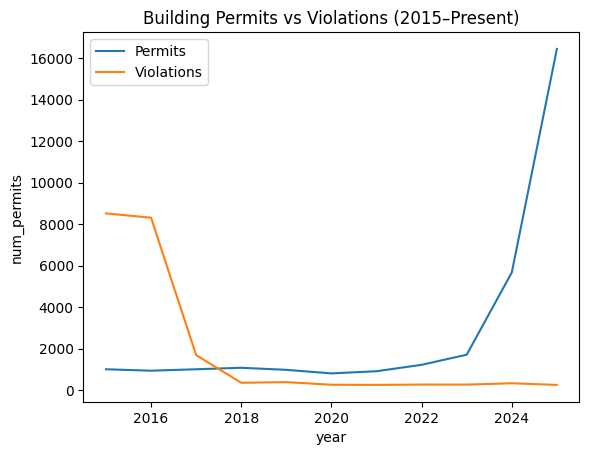

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=merged_df, x="year", y="num_permits", label="Permits")
sns.lineplot(data=merged_df, x="year", y="num_violations", label="Violations")
plt.title("Building Permits vs Violations (2015–Present)")
plt.show()


In [19]:
merged_df[['num_permits','num_violations']].corr()


,num_permits,num_violations
num_permits,1.00000,-0.22405
num_violations,-0.22405,1.00000


# Data Cleaning Street Names

In [20]:
split_cols = permits_df["street_name"].str.rsplit(" ", n=1, expand=True)

permits_df["parsed_street_name"] = split_cols[0]
permits_df["parsed_street_type"] = split_cols[1]

permits_df[["street_name", "parsed_street_name", "parsed_street_type"]].head()


,street_name,parsed_street_name,parsed_street_type
0,CLARK ST,CLARK,ST
1,OAKLEY AVE,OAKLEY,AVE
3,WALLEN AVE,WALLEN,AVE
4,IRON ST,IRON,ST
20,EBERHART AVE,EBERHART,AVE


In [21]:
permits_by_street = (
    permits_df
        .groupby("parsed_street_name")
        .size()
        .reset_index(name="num_permits")
)

print(permits_by_street.head())


  parsed_street_name  num_permits
0              100TH           13
1              101ST            6
2              102ND            6
3              103RD           66
4              104TH            9


In [22]:
violations_by_street = (
    violations_df
        .groupby("street_name")
        .size()
        .reset_index(name="num_violations")
)

print(violations_by_street.head())


  street_name  num_violations
0       100TH               4
1       101ST              29
2       103RD               2
3       104TH              13
4       105TH              11


# Comparing total permits vs total violations by street

In [23]:
street_compare = pd.merge(
    permits_by_street,
    violations_by_street,
    left_on="parsed_street_name",
    right_on="street_name",
    how="inner"
)

street_compare.head()


,parsed_street_name,num_permits,street_name,num_violations
0,100TH,13,100TH,4
1,101ST,6,101ST,29
2,103RD,66,103RD,2
3,104TH,9,104TH,13
4,105TH,18,105TH,11


In [24]:
street_compare["violations_per_permit"] = (
    street_compare["num_violations"] / street_compare["num_permits"]
)


# Match by Street Name and Year

In [25]:
permits_street_year = (
    permits_df.groupby(["parsed_street_name", "year"])
              .size()
              .reset_index(name="num_permits")
)

violations_street_year = (
    violations_df.groupby(["street_name", "year"])
                 .size()
                 .reset_index(name="num_violations")
)


In [26]:
merged_street_year = pd.merge(
    permits_street_year,
    violations_street_year,
    left_on=["parsed_street_name", "year"],
    right_on=["street_name", "year"],
    how="inner"
)

merged_street_year.head()


,parsed_street_name,year,num_permits,street_name,num_violations
0,100TH,2016,1,100TH,3
1,101ST,2016,1,101ST,2
2,101ST,2018,1,101ST,1
3,103RD,2015,1,103RD,1
4,103RD,2017,2,103RD,1


In [27]:
# Street-Ranked Summary Table
street_summary = (
    merged_street_year
        .groupby("parsed_street_name")
        .agg({
            "num_permits": "sum",
            "num_violations": "sum"
        })
        .reset_index()
)

street_summary["violations_per_permit"] = (
    street_summary["num_violations"] / street_summary["num_permits"]
)

# Sort (choose one)
# Most violations:
street_summary.sort_values("num_violations", ascending=False).head()

# Highest violation ratio:
street_summary.sort_values("violations_per_permit", ascending=False).head()


,parsed_street_name,num_permits,num_violations,violations_per_permit
43,61ST,2,56,28.0
136,CLINTON,1,25,25.0
10,14TH,1,23,23.0
452,SCOTT,1,23,23.0
505,WEED,1,21,21.0


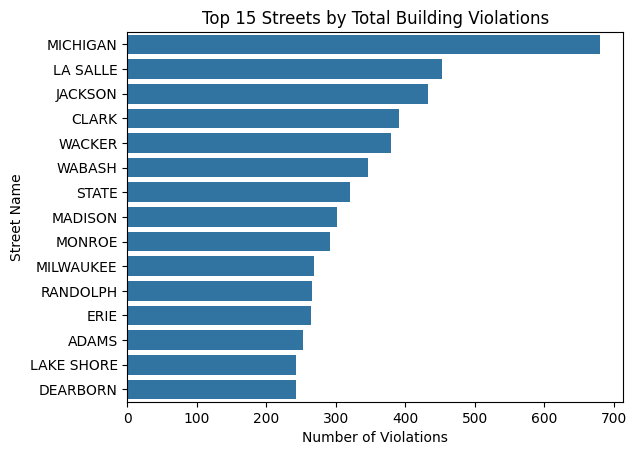

In [28]:
# Top Streets by Violations
top_streets = (
    street_summary
        .sort_values("num_violations", ascending=False)
        .head(15)
)

sns.barplot(
    data=top_streets,
    x="num_violations",
    y="parsed_street_name"
)
plt.title("Top 15 Streets by Total Building Violations")
plt.xlabel("Number of Violations")
plt.ylabel("Street Name")
plt.show()


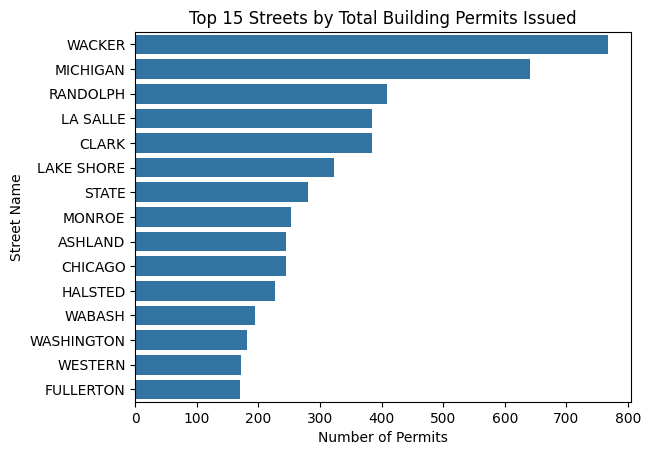

In [29]:
# Top Street by Permit
top_permit_streets = (
    street_summary
        .sort_values("num_permits", ascending=False)
        .head(15)
)

sns.barplot(
    data=top_permit_streets,
    x="num_permits",
    y="parsed_street_name"
)
plt.title("Top 15 Streets by Total Building Permits Issued")
plt.xlabel("Number of Permits")
plt.ylabel("Street Name")
plt.show()


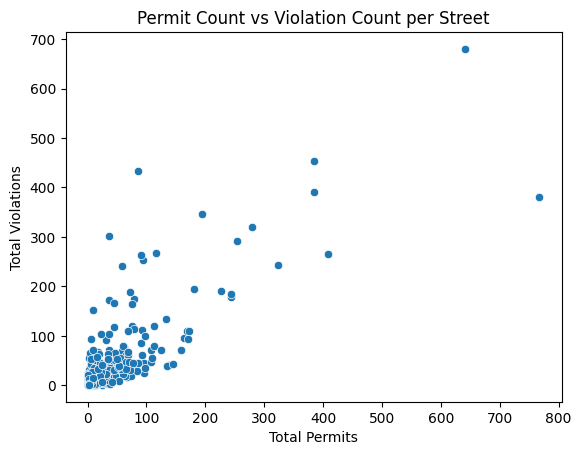

In [30]:
# Relationship between Permits and Violations
sns.scatterplot(
    data=street_summary,
    x="num_permits",
    y="num_violations"
)
plt.title("Permit Count vs Violation Count per Street")
plt.xlabel("Total Permits")
plt.ylabel("Total Violations")
plt.show()
